#### Note
cloud storage not tested
need to use an environment with xesmf

In [26]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import numpy.ma as ma
import glob
import matplotlib.pyplot as plt
import re
import os
import yaml
# from skimage.filters import sobel

In [27]:
#This file contains configuration details like API keys and passwords
global_vars = yaml.safe_load(open('../config.yml', 'r') )

#This has custom functions - several but the fCO2_to_pCO2 function is key
%run './00_custom_functions.ipynb'
#more functions for flux conversions
%run './00_co2_flux_equations.ipynb'

In [28]:
#There are some issues with xesmf installation so we need to point to a file required for the package. See README.md for details.
ESMFMKFILE = global_vars['ESMFMKFILE']
%env ESMFMKFILE $ESMFMKFILE  
import xesmf

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk


In [29]:
# To ingest the raw data downloaded in the previous script, we need to point to the location of the downloads
# Data will be read at this location in folders such as root/SST/originals/ and root/SSS/orginals/
# Processed data will be saved to folders such as root/SST/processed/ 
# Note that data file names within these folders have been hardcoded in each section below
data_folder_root = global_vars['download_folder']
print(f'Data will be processed in: {data_folder_root}')

#This variable sets the output file type. 
#When using cloud storage, it is recommended to use ARCO (Analysis-Ready Cloud-Optimized) formats like Zarr over NetCDF
output_file_type = '.zarr' if data_folder_root[0:5] == 'gs://' else '.nc'
print(f'Files will be outputed as: {output_file_type}')

# The following two variables are used to slice the data to desired time frames for consistency or to backfill historical data with averages. No changes required.
# Given the time range limitiations of the raw data, this primarily affects MLD (1 year repeated) and CHL (linear interpoloation). 
# For other data like SLP, this limits the real-time (experimental) data from recent months
# Note that all input files should have data in at least this time frame
processed_start_yearmonth = '1982-01'  
processed_end_yearmonth = '2023-12'   
processed_start_yearmonth_back_in_time = '1959-01'  

#this is just the year rather than above is yearmonth
processed_start_year = '1982'
processed_end_year = '2023'  
processed_start_year_back_in_time = '1959' 

figsizew, figsizeh = 6, 3  #figure size for maps (width/height)

Data will be processed in: /data/artemis/observations/online_data_for_reconstructions/
Files will be outputed as: .nc


In [30]:
#create desired resolution and time frame
ylat = xr.DataArray(data=[x+.5 for x in range(-90, 90, 1)], dims=['ylat'], coords=dict( ylat=(['ylat'],[x+.5 for x in range(-90, 90, 1)]) ),)
xlon = xr.DataArray(data=[x+.5 for x in range(-180,180,1)], dims=['xlon'], coords=dict( xlon=(['xlon'],[x+.5 for x in range(-180,180,1)]) ),)
ttime = pd.date_range(start=str(processed_start_yearmonth), end=str(processed_end_yearmonth),freq='MS') + np.timedelta64(14, 'D') #time should be monthly on the middle of the month
        #note that the time doesnt affect regridding but we do use this time to overwrite the monthly dates so its consistent
ttime_back_in_time = pd.date_range(start=str(processed_start_yearmonth_back_in_time), end=str(processed_end_yearmonth),freq='MS') + np.timedelta64(14, 'D')  #for back in time portion
    
ideal_grid = xr.Dataset({'time':(['time'],ttime.values), 'latitude':(['latitude'],ylat.values),'longitude':(['longitude'],xlon.values)}) #must be named this way for old XESFM versions
ideal_grid_back_in_time = xr.Dataset({'time':(['time'],ttime_back_in_time.values), 'latitude':(['latitude'],ylat.values),'longitude':(['longitude'],xlon.values)}) 

## Global Ocean Biogeochemistry Model (GOBM)
#### Global Carbon Budget

In [8]:
#assume this is the data from original source we downloaded
models= xr.open_mfdataset(data_folder_root+r'GOBM/originals/GCB-2023*.nc')

In [12]:
models_cut = models.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) #already monthly so select desired years

#regrid to flip longitude
model_regridder = xesmf.Regridder(models_cut, ideal_grid_back_in_time, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
models_cut_out = model_regridder(models_cut, keep_attrs=True)
models_cut_out = models_cut_out.rename({'latitude': 'ylat','longitude': 'xlon'})#rename to be consistent with prior work
models_cut_out = models_cut_out.assign_coords(time=ttime_back_in_time) 

#cut further for just ML XGB
models_cut_out_xgb = models_cut_out.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth)))

In [13]:
models_cut_out

<xarray.Dataset>
Dimensions:    (time: 780, ylat: 180, xlon: 360)
Coordinates:
  * time       (time) datetime64[ns] 1959-01-15 1959-02-15 ... 2023-12-15
  * ylat       (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon       (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    cnrm       (time, ylat, xlon) float64 nan nan nan nan ... 398.3 398.3 398.3
    fesom2     (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan
    ipsl       (time, ylat, xlon) float64 nan nan nan nan ... 365.4 365.9 365.9
    princeton  (time, ylat, xlon) float64 nan nan nan nan ... nan nan nan nan
    mri        (time, ylat, xlon) float64 nan nan nan nan ... 376.3 376.0 375.9
    noresm     (time, ylat, xlon) float64 nan nan nan nan ... 376.9 376.9 376.9
    planktom   (time, ylat, xlon) float64 nan nan nan nan ... 365.5 365.5 365.5
    cesm_ethz  (time, ylat, xlon) float64 nan nan nan nan ... 384.5 384.5 384.5
    mpi        (time, ylat, xlon) float64 nan nan nan nan ... 339.1 339.2 339.3
    access     (time, ylat, xlon) float64 nan nan nan nan ... 318.7 318.7 318.7
Attributes:
    regrid_method:  bilinear

In [15]:
#output both ranges
#note this is duplicative and could be reduced to save on space but reduces need to filter in later script  
#first is full time series back to 1959
#second is years needed for ML (1982-end)
output_xarray_with_date(models_cut_out,     os.path.join(data_folder_root,'GOBM/processed/'), 'GOBM_GCB-2024_fco2-10-models', filetype=output_file_type, overwrite=False)
output_xarray_with_date(models_cut_out_xgb, os.path.join(data_folder_root,'GOBM/processed/'), 'GOBM_GCB-2024_fco2-10-models', filetype=output_file_type, overwrite=False)

Saved GOBM_GCB-2024_fco2-10-models_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/GOBM/processed/
Saved GOBM_GCB-2024_fco2-10-models_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/GOBM/processed/


In [14]:
data_folder_root

'/data/artemis/observations/online_data_for_reconstructions/'

## SOCAT fCO2
for HPD method we dont use the actual SOCAT values but we use it to mask the models
so it's fine to keep it as fCO2 values. Also, now models use fCO2 also so all good.

In [99]:
socat = xr.open_dataset(data_folder_root+r'pCO2/originals/fCO2_SOCOVV_SOCAT-gridded-monthly_2024.nc') 

In [100]:
#get relevant variables and filter for desired years 
co2_processed_end_yearmonth = socat.tmnth.max().data.astype('datetime64[s]').item().strftime('%Y-%m') #Note that fCO2 is only up til 2 years ago if (released every June)
fco2 = socat.fco2_ave_weighted
fco2 = fco2.sel(tmnth=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth))) 
# fco2_sst = socat.sst_ave_weighted
# fco2_sst = fco2_sst.sel(tmnth=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth)))
# fco2_mslp = mslp_out.mslp  #from section above
# fco2_mslp = fco2_mslp.sel(time=slice(str(processed_start_yearmonth),str(co2_processed_end_yearmonth)))

In [103]:
#Realign time to our grid for each available month (ex shift from 16th to 15th for consistency)
fco2_ttime = ttime[pd.DataFrame(ttime,columns=['t']).t.between(fco2.tmnth.min().data.astype('datetime64[s]').item().strftime('%Y-%m'), fco2.tmnth.max().data.astype('datetime64[s]').item(), inclusive='both')]
    #Alternatively can use this: fco2_ttime = pd.date_range(start=fco2.tmnth.min().item(), end=fco2.tmnth.max().item(),freq='MS') + np.timedelta64(14, 'D')
#fco2_ttime

In [108]:
pco2_out = xr.Dataset(  {
                        # 'pco2':(["time","ylat","xlon"],pco2.data),
                        #'socat_mask':(["time","ylat","xlon"],np.where(~np.isnan(pco2),1,np.nan)),  #Prior code included additional variables which are not needed
                        #'socat_sst':(["time","ylat","xlon"],fco2_sst.data),
                        #'mslp':(["time","ylat","xlon"],fco2_mslp.data),
                        'fco2':(["time","ylat","xlon"],fco2.data)
                        },
                        coords={'time': (['time'],fco2_ttime.values),
                          'ylat': (['ylat'],fco2.ylat.data),
                          'xlon': (['xlon'],fco2.xlon.data)}
                    )
# pco2_out.fco2.attrs['units'] = 'uatm'
# pco2_out.pco2.attrs['description'] = 'uses fco2 (weighted), sst (weighted) and MSLP to convert to pCO2 via fCO2_to_pCO2 script'
pco2_out.fco2.attrs['description2'] = 'socat fco2 values <200 and >650 have been changed to nans as a source of quality control' 
#pco2_out.socat_sst.attrs['units'] = 'deg C'
#pco2_out.mslp.attrs['units'] = 'hPa'
pco2_out.fco2.attrs['units'] = 'uatm'
#pco2_out

In [110]:
output_xarray_with_date(pco2_out, data_folder_root+'pCO2/processed/', 'fCO2_SOCAT-weighted')

Saved fCO2_SOCAT-weighted_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/pCO2/processed/


## Ocean/Land Network Mask
This is slightly different than the original code because 1) we use updated, original data sources (which have values between 0-1, not binary) and we dont use the sobel filter


In [17]:
#load and regrid 2 files we downloaded

ds_topo_raw = xr_open_dataset_custom('/data/artemis/workspace/ds4114/online_data/Masks/originals/GEBCO_2023.nc') #topography
ds_lsmask_raw = xr_open_dataset_custom('/data/artemis/workspace/ds4114/online_data/Masks/originals/mask_NOAA_land-sea_20220916.nc', decode_times=False) #land mask

In [18]:
ds_lsmask_raw = ds_lsmask_raw.drop_vars('time_bnds')

ls_regridder = xesmf.Regridder(ds_lsmask_raw, ideal_grid_back_in_time, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
ds_lsmask = ls_regridder(ds_lsmask_raw, keep_attrs=True)
ds_lsmask = ds_lsmask.rename({'latitude': 'lat','longitude': 'lon', 'land':'mask'}) #rename this way to be consistent with prior work
ds_lsmask

<xarray.Dataset>
Dimensions:  (time: 1, lat: 180, lon: 360)
Coordinates:
  * time     (time) float64 -1.577e+07
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    mask     (time, lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:    COARDS
    title:          NCEP reanalysis
    description:    Data is from NMC initialized reanalysis.\nIt consists of ...
    platform:       Model
    history:        created 98/01/08 by Hoop (netCDF4.3.1)\nConverted to chun...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     
    regrid_method:  bilinear

In [19]:
ds_lsmask = ds_lsmask.roll(lon=180, roll_coords='lon') #added
ds_lsmask['lon'] = np.arange(0.5, 360, 1)
#ds_lsmask_raw = ds_lsmask_raw.drop_vars('time_bnds')
#ds_lsmask = ds_lsmask_raw.rename({'land':'mask'})


In [20]:
#ds_lsmask #-90-90 lat, 0-360 lon original
#ds_topo  #-90-90 lat, -180-180 lon original --> 0-360 lon modified
ds_lsmask

<xarray.Dataset>
Dimensions:  (time: 1, lat: 180, lon: 360)
Coordinates:
  * time     (time) float64 -1.577e+07
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    mask     (time, lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:    COARDS
    title:          NCEP reanalysis
    description:    Data is from NMC initialized reanalysis.\nIt consists of ...
    platform:       Model
    history:        created 98/01/08 by Hoop (netCDF4.3.1)\nConverted to chun...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     
    regrid_method:  bilinear

In [21]:
#to get rid of time dimension:
ds2 = ds_lsmask.squeeze("time")
print(ds2)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
    time     float64 -1.577e+07
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    mask     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:    COARDS
    title:          NCEP reanalysis
    description:    Data is from NMC initialized reanalysis.\nIt consists of ...
    platform:       Model
    history:        created 98/01/08 by Hoop (netCDF4.3.1)\nConverted to chun...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     
    regrid_method:  bilinear


In [15]:
#assumed we have downloaded directly and have 2 files
ds_topo = xr_open_dataset_custom('/local/data/artemis/observations/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc') #topography
ds_lsmask = xr_open_dataset_custom('/local/data/artemis/observations/masks/originals/lsmask.nc')  #land sea mask

In [16]:
ds_lsmask

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-10-29
Data variables:
    mask     (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

In [17]:
ds_topo = ds_topo.roll(lon=180, roll_coords='lon')
ds_topo['lon'] = np.arange(0.5, 360, 1)

ds_lsmask = ds_lsmask.sortby('lat').squeeze().drop('time')
data = ds_lsmask['mask'].where(ds_lsmask['mask']==1)
### Define Latitude and Longitude
lon = ds_lsmask['lon']
lat = ds_lsmask['lat']

In [18]:
### Remove coastal points, defined by sobel edge detection
# coast = (sobel(ds_lsmask['mask'])>0)
# data = data.where(coast==0)

### Remove shallow sea, less than 100m
### This picks out the Solomon islands and Somoa
data_cut = data.where(ds_topo['Height']<-100)

### remove arctic
data_cut = data_cut.where(~((lat>79)))
data_cut = data_cut.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
data_cut = data_cut.where(~((lat>67) & (lat<80) & (lon>-180+360) & (lon<-100+360)))

### remove caspian sea, black sea, mediterranean sea, and baltic sea
data_cut = data_cut.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))

### remove hudson bay
data_cut = data_cut.where(~((lat>50) & (lat<70) & (lon>-100+360) & (lon<-70+360)))
data_cut = data_cut.where(~((lat>70) & (lat<80) & (lon>-130+360) & (lon<-80+360)))

### Remove Red sea
data_cut = data_cut.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
data_cut = data_cut.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))

# # Roll to longitude in SOCAT data #
data2 = data_cut.roll(lon=180, roll_coords='lon')
data2['lon'] = np.arange(-179.5, 180, 1)

# data2.attrs["dataset"] = "" #source info to be added
#data

In [19]:
#saving original data mask that doesnt mask out inland seas, etc
data = data
# Roll to longitude in SOCAT data #
data = data.roll(lon=180, roll_coords='lon')
#lon = np.arange(-179.5, 180, 1) #There was a bug on this line; should be like line below 
data['lon'] = np.arange(-179.5, 180, 1)
# data.attrs["dataset"] = "NOAA Optimum Interpolation (OI) SST mask for land/ocean" #source info to be added

In [20]:
del data_cut

In [21]:
#regrid to -180 to 180 long and make a dataset
netmask = xr.Dataset({'net_mask':(['ylat','xlon'],data2.data),
                      'full_mask':(['ylat','xlon'],data.data)
                    },coords={'ylat':(['ylat'],data.lat.values),'xlon':(['xlon'],data.lon.values)})
netmask.net_mask.attrs['desc'] = "1 means ocean; null is land"
netmask.net_mask.attrs['desc full_mask'] = "full mask allows us to include inland seas, arctic, etc in our analysis"
netmask.net_mask.attrs['desc net_mask'] = "net mask masks out inland seas, arctic, etc"

netmask

<xarray.Dataset>
Dimensions:    (ylat: 180, xlon: 360)
Coordinates:
  * ylat       (ylat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon       (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    net_mask   (ylat, xlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    full_mask  (ylat, xlon) float32 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0

In [34]:
#output
output_xarray_with_date(netmask, data_folder_root+'Masks/processed/', 'mask_LEAP_land-sea-network', with_date=False, filetype=output_file_type, overwrite=True)


Saved mask_LEAP_land-sea-network.nc to /local/data/artemis/observations/online_data_for_reconstructions/Masks/processed/


## xCO2 for ML
this is just the global monthly mean time series

In [25]:

fl = os.path.join(data_folder_root,'xCO2/originals/','xCO2_NOAA_xCO2-mm-gl-monthly_197901-202408.csv')
#find number of rows that start with #
exclude = [i for i, line in enumerate(open(fl)) if line.startswith('#')]

esrl = pd.read_csv(fl, skiprows = exclude[0:])


In [29]:
# esrl

In [27]:
#make time the index; drop unneeded columns; convert to xarray
esrl['time'] = esrl.apply(lambda row: datetime.datetime(int(row.year), int(row.month), 15), axis=1) #putting as 15th of the month
esrl['time'] = pd.to_datetime(esrl.time)
esrl.index = pd.DatetimeIndex(esrl.time)

esrl = esrl[['trend']].to_xarray() #we only want the "trend" field because it matches historical work that did not factor seasonality 
esrl_filtered = esrl.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #filter for desired time
esrl_filtered = esrl_filtered.rename({'trend': 'xco2_trend'})
#esrl_filtered

In [31]:
output_xarray_with_date(esrl_filtered, data_folder_root+'xCO2/processed/', 'xCO2_NOAA_xCO2-mm-gl-monthly',filetype=output_file_type, overwrite=False)

Saved xCO2_NOAA_xCO2-mm-gl-monthly_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/xCO2/processed/


## Temperature (SST)
#### NOAA
Currently NOAA is used for ML because it's easy, but we need ERA5 to use for flux calcs (including in xco2 to pco2 calculation) becuase it goes back to 1959

In [11]:
sst = xr.open_dataset(data_folder_root+r'SST/originals/SST_NOAA_OI-V2-HighRes_198109-202408.nc')  
# sst

In [13]:
%%time
sst_filtered = sst.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #already monthly so select desired years
sst_regridder = xesmf.Regridder(sst_filtered, ideal_grid, 'conservative', periodic=True)  #see notes above on why conservative over bilinear
sst_out = sst_regridder(sst_filtered, keep_attrs=True)
#sst_out

CPU times: user 31.5 s, sys: 5.61 s, total: 37.1 s
Wall time: 37.6 s


In [14]:
sst_out = sst_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sst_out = sst_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth

In [39]:
output_xarray_with_date(sst_out, data_folder_root+'SST/processed/', 'SST_NOAA_OI-V2-1x1')

Saved SST_NOAA_OI-V2-1x1_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/SST/processed/


### ERA5 sst (used for atm pco2 calculation because it goes back to 1959)

In [6]:
sst_era5 = xr.open_mfdataset(data_folder_root+r'SST/originals/SST_ECMWF_ERA5-monthly-reanalysis-SST_*.nc') 

In [7]:
sst_era5

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 780)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2023-12-01
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-30 16:32:22 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [8]:
%%time
#Regrid sst_era5
sst_era5_highres = sst_era5.sst - 273.15  #.sel(expver=1) do do not need the experimental/recent data because socat is only up till end of the prior year. Also convert deg K to deg C.
    #Note the expver variable in era5 indicates new experimental data: #https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064
sst_era5_highres = sst_era5_highres.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) #already monthly so select desired years
sst_era5_highres = xr.Dataset({'sst_era5':(['time','latitude','longitude'],sst_era5_highres.data),'time':(['time'],sst_era5_highres.time.data),'latitude':(['latitude'],sst_era5_highres.latitude.data),'longitude':(['longitude'],sst_era5_highres.longitude.data)})
sst_era5_highres_regridder = xesmf.Regridder(sst_era5_highres, ideal_grid, 'bilinear', periodic=True) #See note above about bilinear vs conservative
sst_era5_out = sst_era5_highres_regridder(sst_era5_highres, keep_attrs=False)
#sst_era5_out

CPU times: user 14.1 s, sys: 781 ms, total: 14.9 s
Wall time: 14.9 s


In [10]:
sst_era5_out = sst_era5_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sst_era5_out = sst_era5_out.assign_coords(time=ttime_back_in_time) #overwrite time dimension to be midmonth
sst_era5_out.sst_era5.attrs['units'] = 'deg C (previously deg K)'

In [12]:
output_xarray_with_date(sst_era5_out, data_folder_root+'SST/processed/', 'SST_ECMWF_ERA5-monthly-reanalysis-1x1-SST',overwrite=True)

Saved SST_ECMWF_ERA5-monthly-reanalysis-1x1-SST_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/SST/processed/


## Salinity (SSS)

In [16]:
sss = xr.open_mfdataset(data_folder_root+'SSS/originals/EN.4.2.2.f.analysis.g10.*.nc') 
#sss

In [17]:
%%time
#effectively ignore the depth dimension because we dont need it
sss_nodepth = xr.Dataset({'sss':(['time','lat','lon'],sss.salinity[:,0,:,:].values),'time':(['time'],sss.time.data),'lat':(['lat'],sss.lat.data),'lon':(['lon'],sss.lon.data)})
#Note this removes attributes from SSS raw data so we lose some metadata but this is OK for this analysis
sss_filtered = sss_nodepth.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #filter years

#Regrid lat/lon
sss_regridder = xesmf.Regridder(sss_filtered, ideal_grid, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
sss_out = sss_regridder(sss_filtered, keep_attrs=True)
#sss_out

CPU times: user 1min 5s, sys: 8.26 s, total: 1min 13s
Wall time: 1min 40s


In [18]:
sss_out = sss_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sss_out = sss_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth
#sss_out = sss_out.assign_coords(time=ttime[:-1]) #you can use this line if SSS hasnt updated and we are missing the last month.

In [45]:
output_xarray_with_date(sss_out, data_folder_root+'SSS/processed/', 'SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses')

Saved SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/SSS/processed/


In [15]:
#save separately for a version that goes back to 1959 for use in atmpco2 calculation
sss = xr.open_mfdataset(data_folder_root+'SSS/originals/EN.4.2.2.f.analysis.g10.*.nc') 
#sss


In [16]:
%%time
#effectively ignore the depth dimension because we dont need it
sss_nodepth = xr.Dataset({'sss':(['time','lat','lon'],sss.salinity[:,0,:,:].values),'time':(['time'],sss.time.data),'lat':(['lat'],sss.lat.data),'lon':(['lon'],sss.lon.data)})
#Note this removes attributes from SSS raw data so we lose some metadata but this is OK for this analysis
sss_filtered = sss_nodepth.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) #filter years

#Regrid lat/lon
sss_regridder = xesmf.Regridder(sss_filtered, ideal_grid, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
sss_out = sss_regridder(sss_filtered, keep_attrs=True)
#sss_out

CPU times: user 1min 7s, sys: 8.31 s, total: 1min 15s
Wall time: 1min 41s


In [18]:
sss_out = sss_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sss_out = sss_out.assign_coords(time=ttime_back_in_time) #overwrite time dimension to be midmonth
#sss_out = sss_out.assign_coords(time=ttime[:-1]) #you can use this line if SSS hasnt updated and we are missing the last month.processed_start_yearmonth_back_in_time

In [20]:
output_xarray_with_date(sss_out, data_folder_root+'SSS/processed/', 'SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses')

Saved SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/SSS/processed/


## Mixed Layer Depth (MLD)
#### deBoyer

In [47]:
mld_ds = xr.open_dataset(data_folder_root+r'MLD/originals/MLD_IFREMER-deBoyer_DT02-c1m_2008.nc', decode_times=False)
mld = mld_ds.mld  #just need the mld variable. Data is 2x2 resolution

In [48]:
#there are strange anomalies in the raw data which we are going to filter out
mld_filtered = mld.where(((mld>0)&(mld<5000))) 

#Devan didnt document these commands so I dont know what they do. I looked at difference between mld_filtered and mld_filtered2 and cant see any major differences.
mld_filtered2 = np.where(np.isnan(mld_filtered), ma.array(mld_filtered, mask=np.isnan(mld_filtered)).mean(axis=2)[:,:,np.newaxis], mld_filtered)
mld_filtered2 = np.where(mld_filtered2==0,np.nan,mld_filtered2)

In [59]:
mld_in = xr.Dataset({'mld':(['time','lat','lon'],mld_filtered2),'time':(['time'],range(0,12)),'lat':(['lat'],mld_filtered.lat.values),'lon':(['lon'],mld_filtered.lon.values)})

mld_regridder = xesmf.Regridder(mld_in, ideal_grid, 'bilinear', periodic=True) 
mld_out = mld_regridder(mld_filtered2, keep_attrs=True)
mld_out = np.where(np.isnan(mld_out),0,mld_out)
#mld_out

In [60]:
#we now have 12 months of MLD data, let's replicate for the desired time frame so merging is easier later
mld_out_full = np.empty(shape=(len(ttime),180,360)) 
#now fill array with averaged year
for i, m in enumerate(ttime): 
    mld_out_full[i,:,:] = mld_out[m.month-1,:,:]
#mld_out_full

In [61]:
mld_out_full_xr = xr.Dataset({'mld':(["time","ylat","xlon"],mld_out_full.data)},
                        coords={'time': (['time'],ttime.values),'ylat':(['ylat'],ideal_grid.latitude.data),'xlon':(['xlon'],ideal_grid.longitude.data)})

In [63]:
output_xarray_with_date(mld_out_full_xr, data_folder_root+'MLD/processed/', 'MLD_IFREMER-deBoyer_DT02-c1m-1x1')

Saved MLD_IFREMER-deBoyer_DT02-c1m-1x1_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/MLD/processed/


## Chlorophyll (CHL)

In [65]:
#0) First combine data and filter for the relevant time period. Because CHL data does not have a time dimension in raw data, we need to add it to each file before/during concatenation 
files = glob.glob(data_folder_root+'CHL/originals/*.nc')
chl = xr.concat([add_time_to_globcolour(fl) for fl in files], dim='time')
#chl
chl_filter = chl.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) 

In [66]:
#1) Next we group by month to get and 'average' year
    #Note that we are using data from the desired time frame to calculate an average year. This means past data will change when more years are added.
chl_avg_by_month = chl_filter.CHL1_mean.groupby("time.month").mean("time")  #only need the mean variable
#2) Then we loop that year (duplicate) into two years so that we can linearly interpolate without boundary issues in Jan/Dec. We will only need the middle 12 months.
chl_looped = np.empty(shape=(24,180,360))  #2 years of data.
chl_looped[0:6,:,:] = chl_avg_by_month[6:12,:,:]  #set start of loop to be July to Dec. Winter at the north pole is at the end/start of the year
chl_looped[6:18,:,:] = chl_avg_by_month
chl_looped[18:24,:,:] = chl_avg_by_month[0:6,:,:]  #set end of loop to be Jan to Jun
chl_looped_xr = xr.Dataset({'chl':(['time','lat','lon'],chl_looped)},
                       coords={'time':(['time'],range(0,24)),'lat':(['lat'],chl_avg_by_month.lat.values),'lon':(['lon'],chl_avg_by_month.lon.values)})
chl_looped_interpolated = chl_looped_xr.chl.interpolate_na(dim='time',method='linear',limit=7)
chl_avg_year = chl_looped_interpolated[6:18,:,:]   #the full year we interpolated is in the middle. Starts in Jan.

In [67]:
#3) Now we fill in 1982 to 1997 with that averaged year
earliest_chl_date = chl.time.min().data.astype('datetime64[s]').item()
chl_missing_years = np.empty(shape=(sum(ttime < earliest_chl_date),180,360))  #create empty array of size equal to number of missing months
chl_missing_years = xr.DataArray(chl_missing_years, coords=dict(time=ttime[ttime < earliest_chl_date], lat=chl_avg_year.lat, lon=chl_avg_year.lon), dims=["time", "lat", "lon"]) #make it an xr
chl_avg_fullset = np.empty(shape=(len(ttime),180,360))   #this is just the average which we will use later to fill missing holes from interpolation
#now fill array with averaged year
for i, m in enumerate(ttime):   #loop through months between start and end date
    chl_avg_fullset[i,:,:] = chl_avg_year[m.month-1,:,:]
    if m < earliest_chl_date: 
        chl_missing_years[i,:,:] = chl_avg_year[m.month-1,:,:]
#chl_missing_years.shape

In [68]:
#4) Next, combine the pre-1997 set with the 1998+ data to get a full set. Then interpolate on full set again to fill missing points.
chl_filter_with_missing = xr.concat([chl_missing_years, chl_filter.CHL1_mean], dim='time')
chl_filter_interpolate = chl_filter_with_missing.interpolate_na(dim='time',method='linear',limit=7)

In [69]:
#5) For any remaining missing values that could not be interpolated, we fill with the averaged climatology
chl_filter_interpolate_xr = xr.Dataset({'chl':(['time','lat','lon'],chl_filter_interpolate.data)  #make as a dataset so we can use fillna
                                       #,'clim_repeat':(['time','lat','lon'], chl_avg_fullset)    #This field was used in a prior version of code but is not required
                            }, coords={'time':(['time'],chl_filter_interpolate.time.values),'lat':(['lat'],chl_filter_interpolate.lat.values),'lon':(['lon'],chl_filter_interpolate.lon.values)})
chl_filter_final = chl_filter_interpolate_xr.fillna(chl_avg_fullset) 

In [70]:
#6) Regrid 
chl_regridder = xesmf.Regridder(chl_filter_final, ideal_grid, 'bilinear', periodic=True)
chl_out = chl_regridder(chl_filter_final, keep_attrs=True)
chl_out = chl_out.rename({'latitude': 'ylat','longitude': 'xlon'}) 
chl_out['chl'].attrs['description'] = "Interpolated linearly between months, climatology prior to 1998-01"  
chl_out['chl'].attrs['units'] = "mg / m3"
#chl_out

In [74]:
output_xarray_with_date(chl_out, data_folder_root+'CHL/processed/', 'CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1')

Saved CHL_ARI-ST-GlobColour_L3m-GLOB-100-merged-GSM-CHL1_198201-202312.nc to /data/artemis/observations/online_data_for_reconstructions/CHL/processed/


# Variables needed for flux calculation

## Ice

In [68]:
ice_raw = xr_open_dataset_custom(os.path.join(data_folder_root,'Ice/originals/','Ice_Met-Office-Hadley-Centre_HadISST_187001-202405.nc'))

In [71]:
ice_raw

<xarray.Dataset>
Dimensions:    (time: 1853, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sic        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea ice component
    description:                HadISST sea ice concentration.
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    13/7/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

#### for 1982-end

In [1]:
%%time
ice_filtered = ice_raw.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #already monthly so select desired years
ice_regridder = xesmf.Regridder(ice_filtered, ideal_grid, 'conservative', periodic=True)  #see notes above on why conservative over bilinear
ice_out = ice_regridder(ice_filtered, keep_attrs=True)


In [72]:
ice_out = ice_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
ice_out = ice_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth

In [75]:
output_xarray_with_date(ice_out, data_folder_root+'Ice/processed/', 'HadISST_ice_1x1',overwrite=True)

Saved HadISST_ice_1x1_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/Ice/processed/


#### for 1959-end, back in time

In [70]:
%%time
ice_filtered = ice_raw.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) #already monthly so select desired years
ice_regridder = xesmf.Regridder(ice_filtered, ideal_grid, 'conservative', periodic=True)  #see notes above on why conservative over bilinear
ice_out = ice_regridder(ice_filtered, keep_attrs=True)
ice_out

CPU times: user 3.93 s, sys: 657 ms, total: 4.59 s
Wall time: 4.69 s


<xarray.Dataset>
Dimensions:    (time: 780, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1959-01-16T12:00:00 ... 2023-12-16T12:00:00
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    sic        (time, latitude, longitude) float32 nan nan nan ... 0.99 0.99
Attributes:
    Title:                      Monthly version of HadISST sea ice component
    description:                HadISST sea ice concentration.
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    13/7/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    regrid_method:              conservative

In [72]:
ice_out = ice_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
ice_out = ice_out.assign_coords(time=ttime_back_in_time) #overwrite time dimension to be midmonth

In [75]:
output_xarray_with_date(ice_out, data_folder_root+'Ice/processed/', 'HadISST_ice_1x1',overwrite=True)

Saved HadISST_ice_1x1_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/Ice/processed/


### ERA5 pressure for use in xco2 to pco2 calculations 
(sst is done above)

In [20]:
slp_era5 = xr.open_mfdataset(data_folder_root+r'SLP/originals/SLP_ECMWF_ERA5-monthly-reanalysis-MSLP_*.nc') 

In [22]:
%%time
#Regrid era5
mslp_highres = slp_era5.msl/100  #do do not need the experimental/recent data because socat is only up till end of the prior yer. Also Pa to HPa. 
    #Note the expver variable in era5 indicates new experimental data: #https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064
    #Data in recent 3 months will be blank with expver = 1 but this is expected and filtered next
mslp_highres = mslp_highres.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) #already monthly so select desired years
mslp_highres = xr.Dataset({'mslp':(['time','latitude','longitude'],mslp_highres.data),'time':(['time'],mslp_highres.time.data),'latitude':(['latitude'],mslp_highres.latitude.data),'longitude':(['longitude'],mslp_highres.longitude.data)})
mslp_highres_regridder = xesmf.Regridder(mslp_highres, ideal_grid, 'bilinear', periodic=True) #See note above about bilinear vs conservative
mslp_out = mslp_highres_regridder(mslp_highres, keep_attrs=False)
#mslp_out



CPU times: user 14.1 s, sys: 447 ms, total: 14.5 s
Wall time: 14.6 s


In [24]:
mslp_out = mslp_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
mslp_out = mslp_out.assign_coords(time=ttime_back_in_time) #overwrite time dimension to be midmonth
mslp_out.mslp.attrs['units'] = 'hPa'

In [52]:
output_xarray_with_date(mslp_out, data_folder_root+'SLP/processed/', 'SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP')

Saved SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/SLP/processed/


## atmospheric fCO2, back in time
get the marine boundary layer file. 
use Mauna loa to extend back in time



In [31]:
fl = os.path.join(data_folder_root+'/xCO2/originals/xCO2_NOAA_xCO2-mm-mlo-monthly_197901-202408.csv')

#find number of rows that start with #
exclude = [i for i, line in enumerate(open(fl)) if line.startswith('#')]

mauna = pd.read_csv(fl, skiprows = exclude[0:])

In [32]:
fl = os.path.join(data_folder_root+'/xCO2/originals/xCO2_NOAA_xCO2-mm-gl-monthly_197901-202408.csv')

#find number of rows that start with #
exclude = [i for i, line in enumerate(open(fl)) if line.startswith('#')]

esrl = pd.read_csv(fl, skiprows = exclude[0:])

In [33]:
#probably a better way to do the time slicing to organize but the start dates are fixed
ml_dates   = ttime_back_in_time[(ttime_back_in_time >= '1958-03-01') ]
esrl_dates = ttime_back_in_time[(ttime_back_in_time >= '1979-01-01') ] 
mauna_xr = xr.Dataset({ 'xco2':(["time"],mauna[(mauna.year >= 1959) & (mauna.year <= 2023)].average)},
                        coords={'time': (['time'],ml_dates)})
esrl_xr = xr.Dataset({  'xco2':(["time"],esrl[(esrl.year >= 1959) & (esrl.year <= 2023)].average)},
                        coords={'time': (['time'],esrl_dates)})

### Process marine boundary layer file

In [34]:
#amanda update in Aug 2024:
fl = '/local/data/artemis/observations/globalview/originals/surface.mbl.co2_Aug2024_fromXin.co2'

#if it's available online, the processed file from 01_data_aquisition would be saved here:
# fl = os.path.join(data_folder_root+'/xCO2/originals/xCO2_NOAA_xCO2-mbl-monthly_197901_downloaded_on202407.txt')

In [35]:
# Sine of that latitudes 
sin_of_lats = np.asarray([-1.00, -0.95, -0.90, -0.85, -0.80, -0.75, -0.70, -0.65, -0.60, -0.55,  
-0.50,  -0.45,  -0.40,  -0.35, -0.30,  -0.25,  -0.20,  -0.15,  -0.10,  -0.05,   
0.00,   0.05,   0.10,   0.15,   0.20,   0.25,   0.30,   0.35,   0.40,   0.45,   
0.50,   0.55,   0.60,   0.65,   0.70,   0.75,   0.80,   0.85,   0.90,   0.95,   1.00])

# Convert to degrees 
lats = np.arcsin(sin_of_lats)*180/np.pi

In [36]:
# df = pd.read_table(fl, skiprows=80, delim_whitespace=True, header=None)
df = pd.read_table(fl,delim_whitespace=True, header=None)
df = df.set_index(list(df)[0])#.iloc[:, ::2]
df.columns = lats
df.index.name = 'year'

#### Make mbl file monthly
the NOAA MLB product uses 48 equal time steps each year (~7.6 days)

In [37]:
#get the number of timesteps by looking at the length of the dataframe
firstnum, secondnum = df.shape

In [38]:
### ================================================
### force time vector to be proper format and range
### ================================================
#to change I would need to change the end time and the # of periods. It automatically splits it in the right number of subset and then converts to monthly below.
dates = pd.date_range(start='1979-01-01T00:00:00.000000000', 
                      end='2023-12-31T00:00:00.000000000', periods=firstnum)
da_dates = xr.DataArray(dates, dims='time')

In [40]:
#create an xarray dataset to organize the xco2 data
ds_out = xr.Dataset(
    {
    'XCO2':(['time','lat'], df.values ),
    },

    coords={
    'lat': (['lat'], lats),
    'time': (['time'], da_dates.data)
    })

In [42]:
#take monthly means
ds_out_monthly = ds_out.resample(time='1MS').mean()

In [49]:
#set time on 15th of each month to match all others
#want to make them on the 15th of the month to match others
mbl_ttime = pd.date_range(start=str('1979-01'), end=str('2023-12'),freq='MS') + np.timedelta64(14, 'D') 
ds_out_monthly['time'] = mbl_ttime

#### Extend back in time while still at coarse latitude layers


In [44]:
#set up empty array for the difference cycle, 12 months, 41 lat layers
diff_cycle_mbl = np.empty([41, 12]) #latitude by month because will take a mean over all 540 months to just get a 12 month cycle

In [51]:
#here I decided to do a seasonal cycle difference for just the 1979-1989 years but could do it with more years also, but not needed
for l in range(0,41):
    diff_cycle_mbl[l,:] = (mauna_xr.xco2.sel(time=slice("01-01-1979","12-31-1989"))
                  - ds_out_monthly['XCO2'].isel(lat=l).sel(time=slice("01-01-1979","12-31-1989"))).groupby("time.month").mean("time")


In [52]:
#set up empty numpy array to get monthly back in time for all latitude bands
mbl_back = np.empty([41, 780])

In [53]:
#now we take mauna loa for early years and subtract this diff cycle for each latitude

for l in range(0,41):
    for yr in range(1959,1979): #this is the years we want to replace, but need to plus 1 to the end because it doesnt go through the last number
        mbl_back[l,(yr-1959)*12:(yr-1958)*12] = mauna_xr.xco2.sel(time=slice(f"01-01-{yr}",f"12-31-{yr}")).values - diff_cycle_mbl[l,:] #use difference between mauna loa and esrl for 1980-end to offset early years only available from mauna loa


    mbl_back[l,(1978-1958)*12:(2023-1958)*12] = ds_out_monthly['XCO2'].isel(lat=l).sel(time=slice("1979-01-01","2023-12-31")).values #real values from esrl for glo
    


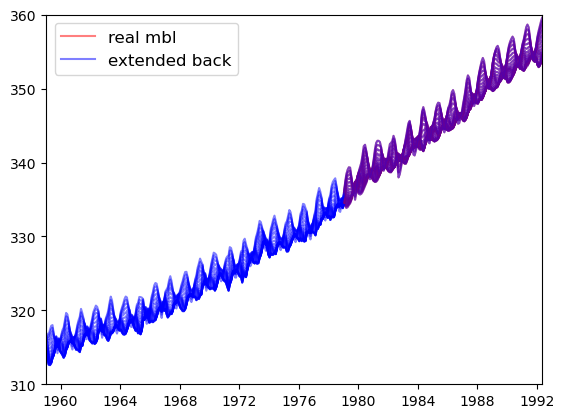

In [54]:
#can take a look at the final version here to see it looks good
plt.plot(ds_out_monthly.time,ds_out_monthly.XCO2[:,0],'-r',alpha=.5,label='real mbl')
plt.plot(mauna_xr.time,mbl_back[0,:],'-b',alpha=.5,label='extended back')
    
for l in range(2,24):
    
    #plot the real mbl and then the set back in time
    plt.plot(ds_out_monthly.time,ds_out_monthly.XCO2[:,l],'-r',alpha=.5)
    plt.plot(mauna_xr.time,mbl_back[l,:],'-b',alpha=.5)
plt.xlim([mauna_xr.time[0],mauna_xr.time[400]])
plt.ylim([310,360])
plt.legend(fontsize=12)

#the real MBL still follows a similar trend at all latitudes. just seasonal cycle really varies.

In [69]:
#make it a data array so easier to work with below:

#create an xarray dataset to organize the xco2 data
mbl_back_in_time = xr.Dataset(
    {
    'XCO2':(['time','lat'], mbl_back.transpose().data ),
    },

    coords={
    'lat': (['lat'], lats),
    'time': (['time'], mauna_xr.time.data)
    })

#### Create File of mbl file  3d monthly


### Repeat along longitude dimension
repeat same value for all longitudes around the globe.

In [70]:
lon = np.arange(-179.5,180,1)
ds_lon = xr.DataArray(np.zeros([len(lon)]), coords=[('lon', lon)])
ds_data, ds_mask = xr.broadcast(mbl_back_in_time, ds_lon)

In [71]:
#regrid lienar interp to go to 1deg in latitude
ds_data_interp = ds_data.interp(lat=np.arange(-89.5, 90, 1), method='linear')

In [76]:
ds_mbl = ds_data_interp
del ds_data_interp

In [81]:
print(ds_mbl)

<xarray.Dataset>
Dimensions:  (time: 780, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-15 1959-02-15 ... 2023-12-15
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    XCO2     (time, lat, lon) float64 313.4 313.4 313.4 ... 427.1 427.1 427.1


#### calculate pCO2 from xco2

In [79]:
#need to get SST, SSS, and MSLP to calcluate pCO2 from xCO2


# ERA5:
SST = xr.open_dataset(f"{data_folder_root}/SST/processed/SST_ECMWF_ERA5-monthly-reanalysis-1x1-SST_195901-202312.nc")
sst = SST.sst_era5.sel(time=slice("01-01-1959","12-31-2023"))
sst = sst.rename({"ylat":"lat","xlon":"lon"})

# EN4.2.1 Salinity:
SSS = xr.open_dataset(f"{data_folder_root}/SSS/processed/SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_195901-202312.nc")
sss = SSS.sel(time=slice("01-01-1959","12-31-2023"))
sss = sss.rename({"ylat":"lat","xlon":"lon"})

# SLP from ERA5:
era5 = xr.open_dataset(f"{data_folder_root}/SLP/processed/SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_195901-202312.nc")
era5 = era5.sel(time=slice("01-01-1959","12-31-2023"))
era5 = era5.rename({"ylat":"lat","xlon":"lon"})
slp = era5.mslp# / 100 # Pascals to hPa this was done in preprocessing. Should check, values should be in the 1000s


In [80]:
del SST, SSS, era5

In [82]:
#
mbl_pco2_backintime = calc_pco2_from_xco2(ds_mbl.XCO2,slp,sst,sss.sss) 

In [84]:
#also convert pco2 to fco2
mbl_fco2_backintime = pCO2_to_fCO2(mbl_pco2_backintime, sst, slp, tempEQ_C=None)


/tmp/ipykernel_76594/3375330731.py:60: Warning: There are 8 values that do not fall within the given limits (270, 318.5) of temperature (K)
  warn(msg, Warning)


In [85]:
#these fco2 files are now numpy arrays so need to make data arrays

mbl_fco2_backintime = xr.DataArray(mbl_fco2_backintime, 
coords={'time': mbl_pco2_backintime.time,'lat': mbl_pco2_backintime.lat,'lon': mbl_pco2_backintime.lon}, 
dims=[ "time","lat", "lon"])

### save mbl extended back in time here
xco2, pco2, and fco2 all in one place

In [87]:
mbl_extended = xr.Dataset(  {
                        'atm_pco2':(["time","ylat","xlon"],mbl_pco2_backintime.data),
                        'atm_fco2':(["time","ylat","xlon"],mbl_fco2_backintime.data),
                        'atm_xco2':(["time","ylat","xlon"],ds_mbl.XCO2.data)
                        },
                        coords={'time': (['time'],ds_mbl.time.values),
                          'ylat': (['ylat'],mbl_pco2_backintime.lat.data),
                          'xlon': (['xlon'],mbl_pco2_backintime.lon.data)}
                    )
mbl_extended.atm_fco2.attrs['units'] = 'uatm'
mbl_extended.atm_pco2.attrs['units'] = 'uatm'
mbl_extended.atm_xco2.attrs['units'] = 'ppm'
mbl_extended.atm_xco2.attrs['description'] = 'noaa marine boundary layer surface product, available: https://gml.noaa.gov/ccgg/mbl/data.php'
mbl_extended.atm_xco2.attrs['description2'] = 'latitude-varying when downloaded and avgd to monthly '

mbl_extended.atm_pco2.attrs['description'] = 'marine boundary layer surface values which vary by latitude' 
mbl_extended.atm_pco2.attrs['description2'] = 'calculated a mean seasonal cycle for 1979-1989 at each lat of xco2 from MBL'
mbl_extended.atm_pco2.attrs['description3'] = 'calcluated a seasonal cycle difference between Mauna Loa and MBL for each lat'
mbl_extended.atm_pco2.attrs['description4'] = ' back in time done using the seasonal correction for each latitude pre 1979, applied to Mauna Loa seasonal time series'
mbl_extended.atm_pco2.attrs['description5'] = ' pco2 is calculated from xco2 using ERA SST and SLP and Hadley SSS. Water vapor correction included'



mbl_extended.atm_fco2.attrs['description'] = 'same method as pco2 and then fco2 conversion is done'
mbl_extended.atm_fco2.attrs['description2'] = 'uses ERA5 sst and MSLP to convert to fCO2 via pCO2_to_fCO2 script'


mbl_extended.attrs['created_by'] = "A Fay, atm_co2_comparisons.ipynb"  
# mbl_extended.to_netcdf(f"{data_folder_root}/xCO2/processed/global_monthly_pco2_fco2_1959-2023.nc")


#could also save this way, but hard coded above:
output_xarray_with_date(mbl_extended, data_folder_root+'xCO2/processed/', 'global_monthly_pco2_fco2_1959-2023.nc',overwrite=True)

#mbl_extended

Saved global_monthly_pco2_fco2_1959-2023_195901-202312.nc to /data/artemis/observations/online_data_for_reconstructions/xCO2/processed/


## Coastal File back in time
Coastal climatology (Landschutzer et al. 2020)
https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/MPI-ULB-SOM_FFN_clim.html
note that this is 12 months long and is pCO2
There is no specific reference year for this climatology but it is made with data from 1998–2015 so we choose to assign a reference year of the middle (2006).

file is downloaded in 01, and process to be monthly 1x1 here in 02
extended back in time and used for filling is now it's own step and done in a workbook: 06_coastal_filling.ipynb

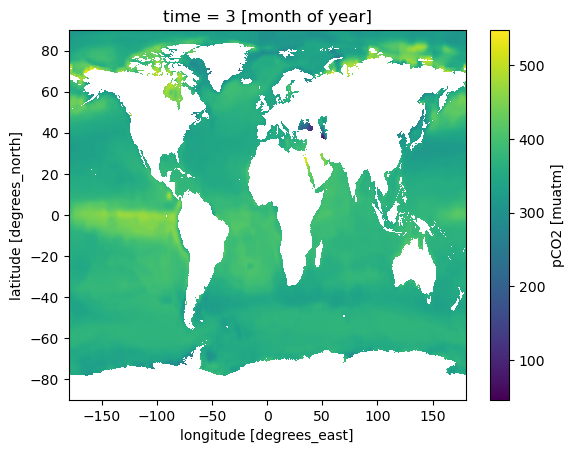

In [6]:
coastal_clim = xr.open_dataset(f"{data_folder_root}/pCO2/originals/coastal_climatology_Landschutzer2020.nc")
# coastal_clim = xr.open_dataset('/data/artemis/observations/pCO2_products/originals/SOMFFN/MPI-ULB-SOM_FFN_clim.nc') 
#fill negative values (land) with nan
coastal_clim = coastal_clim.where(coastal_clim != -999)

coastal_clim.pco2[2,:,:].plot()

In [7]:

#create desired resolution and time frame
ylat = xr.DataArray(data=[x+.5 for x in range(-90, 90, 1)], dims=['ylat'], coords=dict( ylat=(['ylat'],[x+.5 for x in range(-90, 90, 1)]) ),)
xlon = xr.DataArray(data=[x+.5 for x in range(-180,180,1)], dims=['xlon'], coords=dict( xlon=(['xlon'],[x+.5 for x in range(-180,180,1)]) ),)
ttimeC = pd.date_range(start=str('2006-01'), end=str('2006-12'),freq='MS') + np.timedelta64(14, 'D') #time should be monthly on the middle of the month
        #note that the time doesnt affect regridding but we do use this time to overwrite the monthly dates so its consistent
    
   

In [8]:
#Regrid lat/lon
coastal_clim_regridder = xesmf.Regridder(coastal_clim, ideal_grid, 'conservative', periodic=True)  #see notes above on why conservative over bilinear
coastal_clim_out = coastal_clim_regridder(coastal_clim, keep_attrs=True)
#coastal_clim_out

In [9]:
coastal_clim_out = coastal_clim_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
coastal_clim_out = coastal_clim_out.assign_coords(time=ttimeC) #overwrite time dimension to be midmonth

In [26]:
#convert to fco2

#get relevant variables and filter for desired years 
coastal_pco2 = coastal_clim_out.pco2.data

pco2_sst = sst_out.sst
pco2_sst = pco2_sst.sel(time=slice(str('2006-01'),str('2006-12')))

pco2_mslp = mslp_out.mslp  #from section above
pco2_mslp = pco2_mslp.sel(time=slice(str('2006-01'),str('2006-12')))


coastal_fco2 = pCO2_to_fCO2(coastal_pco2, pco2_sst, pco2_mslp, tempEQ_C=None)


In [28]:
fco2_out = xr.Dataset(  {
                        # 'pco2':(["time","ylat","xlon"],pco2.data),
                        'fco2':(["time","ylat","xlon"],coastal_fco2.data)
                        },
                        coords={'time': (['time'],ttimeC.values),
                          'ylat': (['ylat'],coastal_clim_out.ylat.data),
                          'xlon': (['xlon'],coastal_clim_out.xlon.data)}
                    )
fco2_out.fco2.attrs['description'] = 'uses pco2, noaa sst and ERA5 MSLP to convert pCO2 to fCO2 using pCO2_to_fCO2 script'
#pco2_out.socat_sst.attrs['units'] = 'deg C'
#pco2_out.mslp.attrs['units'] = 'hPa'
fco2_out.fco2.attrs['units'] = 'uatm'
#pco2_out

In [30]:
output_xarray_with_date(fco2_out, data_folder_root+'pCO2/processed/', 'MPI_ULB_SOMFFN_coastal_clim_fco2.nc')


Cancelling output - MPI_ULB_SOMFFN_coastal_clim_fco2_200601-200612.nc already exists in /data/artemis/observations/online_data_for_reconstructions/pCO2/processed/


## Wind
ERA5 winds

In [29]:
#Will just do for 2023 here and then can concat to previous file
# processed_start_yearmonth_wind = '2023-01'

In [6]:
#calcluate windspeed from u and v compoents and then average to monthly while also getting std and mean square of hourly wind speed for flux calcs
#now lets make it into a loop to do a whole year
#this comes from ERA5 download workbook

#this takes awhile for even one year. would need to make a loop or rerun over and over again for each year if you need more years.

ws10 = np.empty(shape=(12,721,1440)) #month x lat x lon of ERA files
ws_std = np.empty(shape=(12,721,1440)) #month x lat x lon of ERA files
ws_sqr = np.empty(shape=(12,721,1440)) #month x lat x lon of ERA files


year = 2023
mon_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
for month in range(0,12):
    # ds = xr.open_dataset(f'/data/artemis/observations/ERA5/Winds_{year}-{mon_list[month]}.nc')
    ds = xr.open_dataset(f'{data_folder_root}/Wind/originals/Wind_ECMWF_ERA5-10m-uv-wind_{year}-{mon_list[month]}.nc')
    #/data/artemis/observations/online_data_for_reconstructions/Wind/originals/Wind_ECMWF_ERA5-10m-uv-wind_2023-12.nc
    # calculate wind speed
    ds = ds.assign(ws=np.sqrt(ds['u10']**2 + ds['v10']**2)) #this calclullates 10m winds!

    # local attribute
    ds['ws'].attrs = {'units': 'm/s', 'long_name': 'wind speed'}

    ds['ws'].to_dataset()

    #Then, average those hourly speeds over the month (and calc std of them over the month)
    #this is all for 1 month so just average and std over all time in this file
    #note: these are all for one individal month so they wont have a time component after this.
    ws10[month,:,:] = ds.ws.mean("time")
    # print(ws10)
    ws_std[month,:,:] = ds.ws.std("time")
    ws_sqr[month,:,:] = (ds.ws*ds.ws).mean("time") #Mean square of hourly wind speed
    
    del ds
#these are all numpy arrays now and 12 months but still need to be regridded to 1x1 degree

In [8]:
#load one month of original file so we can get lat/lon for regridding:
ds = xr.open_dataset(f'{data_folder_root}/Wind/originals/Wind_ECMWF_ERA5-10m-uv-wind_2023-01.nc')
ds.dims

Frozen({'longitude': 1440, 'latitude': 721, 'time': 744})

In [9]:
#regrid code form regrid_ERA5 workbook

#you have 3 variables to regrid:
 # ws10,ws_std, ws_sqr
    
# Interpolate onto ideal grid.
#grab just one year of ideal grid defined above
grid_tmp = ideal_grid_back_in_time.sel(time=slice(str('2023-01'),str('2023-12')))

# era_grid = xr.Dataset({'lat':(['lat'],ds.latitude.values),'lon':(['lon'],ds.longitude.values)})
# sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
ws_in = xr.Dataset({'ws':(['time','lat','lon'],ws10),'time':(['time'],grid_tmp.time.data),'lat':(['lat'],ds.latitude.values),'lon':(['lon'],ds.longitude.values)})
ws_square_in = xr.Dataset({'ws2':(['time','lat','lon'],ws_sqr),'time':(['time'],grid_tmp.time.data),'lat':(['lat'],ds.latitude.values),'lon':(['lon'],ds.longitude.values)})
ws_std_in = xr.Dataset({'ws_std':(['time','lat','lon'],ws_std),'time':(['time'],grid_tmp.time.data),'lat':(['lat'],ds.latitude.values),'lon':(['lon'],ds.longitude.values)})
# ws_2nd_in = xr.Dataset({'ws_2nd':(['time','lat','lon'],ws_2nd),'time':(['time'],grid_tmp.time.data),'lat':(['lat'],ds.latitude.values),'lon':(['lon'],ds.longitude.values)})

#this sets up the regridder
regridder = xesmf.Regridder(ws_in, grid_tmp, 'bilinear',periodic=True)

In [27]:
#run regridding here
ws_out = regridder(ws_in.ws)
ws_square_out = regridder(ws_square_in.ws2)
ws_std_out = regridder(ws_std_in.ws_std)
# ws_2nd_out = regridder(ws_2nd_in.ws_2nd)

In [37]:
##########################
wind_out = xr.Dataset({
                        'ws10':(["time","ylat","xlon"],ws_out.data),
                        'ws_squared':(["time","ylat","xlon"],ws_square_out.data),
                        'ws_std':(["time","ylat","xlon"],ws_std_out.data)},
                        # 'ws_2nd':(["time","ylat","xlon"],ws_2nd_out)},
                        coords={'time': (['time'],ws_out.time.data),
                        'ylat': (['ylat'],ws_out.latitude.data),
                        'xlon':(['xlon'],ws_out.longitude.data)})

wind_out.ws10.attrs['units'] = 'm s^-1'  
wind_out.ws10.attrs['long_name'] = '10 metre wind speed' 
wind_out.ws10.attrs['description'] = 'calculated by (ws=np.sqrt(ds[u10]**2 + ds[v10]**2)) from hourly winds' 

wind_out.ws_squared.attrs['units'] = 'm^2 s^-2'  
wind_out.ws_squared.attrs['long_name'] = '10 metre wind speed, squared' 
wind_out.ws_squared.attrs['description'] = 'Mean square of hourly wind speed'

wind_out.ws_std.attrs['units'] = 'm s^-1'  
wind_out.ws_std.attrs['long_name'] = 'standard deviation of hourly 10 meter wind speed over the month' 



In [39]:
output_xarray_with_date(wind_out, os.path.join(data_folder_root,'Wind/processed/'), 'Wind_ECMWF_ERA5-monthly-10m-uv-wind-1x1', filetype=output_file_type, overwrite=False)

Saved Wind_ECMWF_ERA5-monthly-10m-uv-wind-1x1_202301-202312.nc to /data/artemis/observations/online_data_for_reconstructions/Wind/processed/
